
# Company Failure Prediction: Predict2Protect

### Initial Setup and Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# Preprocessing and Modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from imblearn.ensemble import BalancedRandomForestClassifier

# Metrics
from sklearn.metrics import (
    classification_report,
    f1_score,
    make_scorer,
    average_precision_score,
    precision_recall_curve
)

# Hyperparameter Tuning
import optuna

# Set a consistent style for plots
sns.set(style="whitegrid")


### Load Training Data


In [13]:

data = pd.read_csv('train.csv', index_col=0)
print(f"Training data loaded successfully. Shape: {data.shape}")
print("\n--- Initial Data Info ---")
data.info()

Training data loaded successfully. Shape: (62789, 23)

--- Initial Data Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 62789 entries, 0 to 78681
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   company_name  62789 non-null  object 
 1   fyear         62789 non-null  float64
 2   status_label  62789 non-null  object 
 3   X1            62789 non-null  float64
 4   X2            62789 non-null  float64
 5   X3            62789 non-null  float64
 6   X4            62789 non-null  float64
 7   X5            62789 non-null  float64
 8   X6            62789 non-null  float64
 9   X7            62789 non-null  float64
 10  X8            62789 non-null  float64
 11  X9            62789 non-null  float64
 12  X10           62789 non-null  float64
 13  X11           62789 non-null  float64
 14  X12           62789 non-null  float64
 15  X13           62789 non-null  float64
 16  X14           62789 non-null  float6


### Initial Analysis - Class Imbalance


--- Target Class Distribution (Per Company) ---
status_label
alive     6689
failed     487
Name: count, dtype: int64


/var/folders/1t/zs8kcpkx1xx10plw7bt_dh9c0000gn/T/ipykernel_89549/4117134871.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




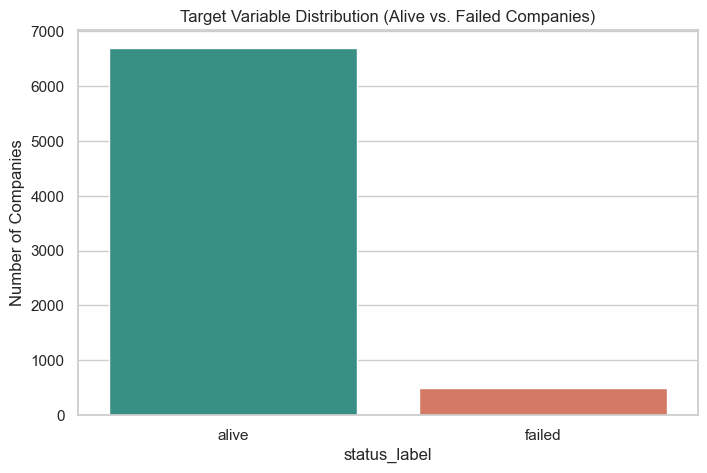


Analysis: The dataset is HIGHLY imbalanced. This confirms my choice of BalancedRandomForestClassifier.


In [14]:
# Count each company only once
target_distribution = data.drop_duplicates(subset=['company_name'])['status_label'].value_counts()

print("--- Target Class Distribution (Per Company) ---")
print(target_distribution)

# Plot the distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=target_distribution.index, y=target_distribution.values, palette=['#2a9d8f', '#e76f51'])
plt.title('Target Variable Distribution (Alive vs. Failed Companies)')
plt.ylabel('Number of Companies')
plt.show()

print("\nAnalysis: The dataset is HIGHLY imbalanced. This confirms my choice of BalancedRandomForestClassifier.")


### Feature Engineering Strategy: The "Many-to-One" Transform

Core challenge is to convert the multi-year data (many rows per company) into a single row of features. I will do this by creating features that describe the full flow of the company, not just a single snapshot.

I'll first create 5 powerful financial ratios for each year, then I'll aggregate all 23 features (18 original + 5 new) using four methods:
1.  `_mean`: The average value over its history (its state).
2.  `_std`: The standard deviation (its volatility).
3.  `_last`: The most recent value (its final state).
4.  `_get_slope`: The trend over time (its momentum).

This will create a rich, 93-feature dataset.


In [4]:
def get_slope(series):
    """
    Calculates the slope of a time-series using linear regression.
    """
    y = series.values
    x = np.arange(len(y))
    if len(y) < 2: return 0.0
    mask = ~np.isnan(y)
    x, y = x[mask], y[mask]
    if len(y) < 2: return 0.0
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return slope

In [5]:
def engineer_features(df):
    """
    Transforms the panel data into a flat file (one-row-per-company)
    with 93 engineered features.
    """
    df_temp = df.copy()
    df_temp = df_temp.sort_values(by=['company_name', 'fyear'])

    # 1. Create 5 powerful financial ratios for each year
    df_temp['Current_Ratio'] = np.where(df_temp['X14'] != 0, df_temp['X1'] / df_temp['X14'], np.nan)
    df_temp['Debt_to_Asset_Ratio'] = np.where(df_temp['X10'] != 0, df_temp['X17'] / df_temp['X10'], np.nan)
    df_temp['ROA'] = np.where(df_temp['X10'] != 0, df_temp['X6'] / df_temp['X10'], np.nan)
    df_temp['Profit_Margin'] = np.where(df_temp['X9'] != 0, df_temp['X6'] / df_temp['X9'], np.nan)
    df_temp['Operational_Efficiency_Ratio'] = np.where(df_temp['X18'] != 0, df_temp['X16'] / df_temp['X18'], np.nan)

    df_temp.replace([np.inf, -np.inf], np.nan, inplace=True)
    grouped = df_temp.groupby('company_name')

    # 2. Define the 23 base features to aggregate
    features_to_agg = [
        'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10',
        'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18',
        'Current_Ratio', 'Debt_to_Asset_Ratio', 'ROA', 'Profit_Margin',
        'Operational_Efficiency_Ratio'
    ]

    # 3. Create the aggregation dictionary
    agg_dict = {}
    for feat in features_to_agg:
        agg_dict[feat] = ['mean', 'std', 'last', get_slope]

    # Also grab the target label and number of years
    # 'status_label' will not be present in test.csv, so we check first
    if 'status_label' in df.columns:
        agg_dict['status_label'] = 'first'
    agg_dict['fyear'] = ['count']

    # 4. Apply Aggregations
    print("\nStarting feature aggregation...")
    data_flat = grouped.agg(agg_dict)
    print("Aggregation complete.")

    # 5. Clean Up Column Names
    data_flat.columns = ['_'.join(col) for col in data_flat.columns.values]

    # Rename columns that weren't part of the main list
    if 'status_label_first' in data_flat.columns:
        data_flat.rename(columns={
            'status_label_first': 'status_label',
            'fyear_count': 'num_years'
        }, inplace=True)
    else:
        data_flat.rename(columns={'fyear_count': 'num_years'}, inplace=True)

    # Fill NaNs. (e.g., 'std' is NaN for companies with 1 year)
    std_cols = [col for col in data_flat.columns if '_std' in col]
    data_flat[std_cols] = data_flat[std_cols].fillna(0)
    data_flat = data_flat.fillna(0)
    data_flat = data_flat.reset_index()

    return data_flat


### Create and Split the Final Dataset



In [6]:
# Run the engineering function on the training data
data_flat = engineer_features(data)
print(f"\nTransformed training data shape: {data_flat.shape}")

# Create the target variable (y) and features (X)
y = data_flat['status_label'].apply(lambda x: 1 if x == 'failed' else 0)
X = data_flat.drop(columns=['company_name', 'status_label']) # Drop identifiers and target

# Save the column names in order. We'll need this for the test set.
training_columns = X.columns.tolist()

print(f"Feature matrix X shape: {X.shape}")
print(f"Target vector y shape: {y.shape}")

# Create the stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,      # 25% for testing
    random_state=42,     # For reproducible results
    stratify=y           # CRITICAL for imbalance
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


Starting feature aggregation...
Aggregation complete.

Transformed training data shape: (7176, 95)
Feature matrix X shape: (7176, 93)
Target vector y shape: (7176,)
X_train shape: (5382, 93)
X_test shape: (1794, 93)



### Baseline Model (BalancedRandomForest)

In [7]:
print("--- Training Baseline Model: BalancedRandomForestClassifier ---")

# Initialize the model
brf_baseline = BalancedRandomForestClassifier(
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)

brf_baseline.fit(X_train, y_train)
y_pred_baseline = brf_baseline.predict(X_test)

baseline_macro_f1 = f1_score(y_test, y_pred_baseline, average='macro')

print(classification_report(y_test, y_pred_baseline, target_names=['alive (0)', 'failed (1)']))
print(f"Baseline Macro F1 Score: {baseline_macro_f1:.4f}")

--- Training Baseline Model: BalancedRandomForestClassifier ---
              precision    recall  f1-score   support

   alive (0)       0.97      0.86      0.91      1672
  failed (1)       0.25      0.62      0.36       122

    accuracy                           0.85      1794
   macro avg       0.61      0.74      0.64      1794
weighted avg       0.92      0.85      0.88      1794

Baseline Macro F1 Score: 0.6363



### Hyperparameter Tuning with Optuna

In [8]:
def objective(trial):
    """
    Optuna objective function for BalancedRandomForestClassifier.
    """

    # 1. Define the hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 50, log=True),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])
    }

    model = BalancedRandomForestClassifier(**params, random_state=42, n_jobs=-1)

    # 3. Define the stratified cross-validation
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # 4. Define the scorer
    macro_f1_scorer = make_scorer(f1_score, average='macro')

    # 5. Run CV
    scores = cross_val_score(
        model, X_train, y_train, cv=cv, scoring=macro_f1_scorer, n_jobs=-1
    )

    # 6. Return the mean score
    return scores.mean()

print("--- Starting Optuna Hyperparameter Tuning (50 Trials) ---")

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n--- Tuning Complete ---")

[I 2025-11-03 18:20:38,339] A new study created in memory with name: no-name-5f35cea9-1867-4297-b287-4550a95762b4


--- Starting Optuna Hyperparameter Tuning (50 Trials) ---


Best trial: 0. Best value: 0.58406:   2%|▏         | 1/50 [00:02<02:07,  2.59s/it]

[I 2025-11-03 18:20:40,932] Trial 0 finished with value: 0.5840602809726222 and parameters: {'n_estimators': 487, 'max_depth': 8, 'max_features': 0.20929697602421585, 'min_samples_split': 12, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5840602809726222.


Best trial: 0. Best value: 0.58406:   4%|▍         | 2/50 [00:05<02:23,  2.99s/it]

[I 2025-11-03 18:20:44,202] Trial 1 finished with value: 0.5822220621515495 and parameters: {'n_estimators': 491, 'max_depth': 22, 'max_features': 0.8694780910217315, 'min_samples_split': 10, 'min_samples_leaf': 10, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5840602809726222.


Best trial: 0. Best value: 0.58406:   6%|▌         | 3/50 [00:08<02:09,  2.74s/it]

[I 2025-11-03 18:20:46,653] Trial 2 finished with value: 0.5788344684102783 and parameters: {'n_estimators': 402, 'max_depth': 9, 'max_features': 0.6783978444925495, 'min_samples_split': 16, 'min_samples_leaf': 10, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5840602809726222.


Best trial: 0. Best value: 0.58406:   8%|▊         | 4/50 [00:10<01:55,  2.51s/it]

[I 2025-11-03 18:20:48,806] Trial 3 finished with value: 0.5812749027326044 and parameters: {'n_estimators': 328, 'max_depth': 35, 'max_features': 0.6144513516349013, 'min_samples_split': 10, 'min_samples_leaf': 11, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5840602809726222.


Best trial: 0. Best value: 0.58406:  10%|█         | 5/50 [00:11<01:34,  2.10s/it]

[I 2025-11-03 18:20:50,175] Trial 4 finished with value: 0.5714256719143159 and parameters: {'n_estimators': 192, 'max_depth': 45, 'max_features': 0.22919748918702618, 'min_samples_split': 5, 'min_samples_leaf': 14, 'criterion': 'gini'}. Best is trial 0 with value: 0.5840602809726222.


Best trial: 0. Best value: 0.58406:  12%|█▏        | 6/50 [00:13<01:29,  2.03s/it]

[I 2025-11-03 18:20:52,077] Trial 5 finished with value: 0.5709788231859871 and parameters: {'n_estimators': 849, 'max_depth': 12, 'max_features': 0.27909924176526146, 'min_samples_split': 16, 'min_samples_leaf': 17, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5840602809726222.


Best trial: 6. Best value: 0.587633:  14%|█▍        | 7/50 [00:15<01:18,  1.81s/it]

[I 2025-11-03 18:20:53,442] Trial 6 finished with value: 0.5876334867543701 and parameters: {'n_estimators': 212, 'max_depth': 16, 'max_features': 0.8473385905070604, 'min_samples_split': 14, 'min_samples_leaf': 6, 'criterion': 'entropy'}. Best is trial 6 with value: 0.5876334867543701.


Best trial: 6. Best value: 0.587633:  16%|█▌        | 8/50 [00:16<01:11,  1.71s/it]

[I 2025-11-03 18:20:54,921] Trial 7 finished with value: 0.5704784394570777 and parameters: {'n_estimators': 663, 'max_depth': 16, 'max_features': 0.28015472651471535, 'min_samples_split': 2, 'min_samples_leaf': 17, 'criterion': 'gini'}. Best is trial 6 with value: 0.5876334867543701.


Best trial: 6. Best value: 0.587633:  18%|█▊        | 9/50 [00:18<01:16,  1.87s/it]

[I 2025-11-03 18:20:57,138] Trial 8 finished with value: 0.5858773298282394 and parameters: {'n_estimators': 771, 'max_depth': 42, 'max_features': 0.40860852466154707, 'min_samples_split': 9, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 6 with value: 0.5876334867543701.


Best trial: 6. Best value: 0.587633:  20%|██        | 10/50 [00:23<01:47,  2.69s/it]

[I 2025-11-03 18:21:01,680] Trial 9 finished with value: 0.5816584947909845 and parameters: {'n_estimators': 734, 'max_depth': 11, 'max_features': 0.9418221469022467, 'min_samples_split': 18, 'min_samples_leaf': 11, 'criterion': 'entropy'}. Best is trial 6 with value: 0.5876334867543701.


Best trial: 6. Best value: 0.587633:  22%|██▏       | 11/50 [00:23<01:20,  2.05s/it]

[I 2025-11-03 18:21:02,289] Trial 10 finished with value: 0.559703737779949 and parameters: {'n_estimators': 116, 'max_depth': 5, 'max_features': 0.7757898047599541, 'min_samples_split': 20, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 6 with value: 0.5876334867543701.


Best trial: 11. Best value: 0.593653:  24%|██▍       | 12/50 [00:27<01:31,  2.41s/it]

[I 2025-11-03 18:21:05,523] Trial 11 finished with value: 0.5936534056515023 and parameters: {'n_estimators': 983, 'max_depth': 26, 'max_features': 0.470873272310646, 'min_samples_split': 13, 'min_samples_leaf': 5, 'criterion': 'gini'}. Best is trial 11 with value: 0.5936534056515023.


Best trial: 12. Best value: 0.595736:  26%|██▌       | 13/50 [00:29<01:25,  2.30s/it]

[I 2025-11-03 18:21:07,572] Trial 12 finished with value: 0.5957364826466499 and parameters: {'n_estimators': 612, 'max_depth': 24, 'max_features': 0.44457744484122874, 'min_samples_split': 14, 'min_samples_leaf': 4, 'criterion': 'gini'}. Best is trial 12 with value: 0.5957364826466499.


Best trial: 13. Best value: 0.597934:  28%|██▊       | 14/50 [00:32<01:38,  2.74s/it]

[I 2025-11-03 18:21:11,306] Trial 13 finished with value: 0.5979341486529316 and parameters: {'n_estimators': 1000, 'max_depth': 25, 'max_features': 0.4846295952425423, 'min_samples_split': 13, 'min_samples_leaf': 2, 'criterion': 'gini'}. Best is trial 13 with value: 0.5979341486529316.


Best trial: 14. Best value: 0.604612:  30%|███       | 15/50 [00:36<01:46,  3.04s/it]

[I 2025-11-03 18:21:15,066] Trial 14 finished with value: 0.6046115237174727 and parameters: {'n_estimators': 984, 'max_depth': 25, 'max_features': 0.454387296329643, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 14 with value: 0.6046115237174727.


Best trial: 15. Best value: 0.604866:  32%|███▏      | 16/50 [00:41<01:56,  3.43s/it]

[I 2025-11-03 18:21:19,380] Trial 15 finished with value: 0.6048659736696141 and parameters: {'n_estimators': 982, 'max_depth': 32, 'max_features': 0.5567899106800586, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 15 with value: 0.6048659736696141.


Best trial: 15. Best value: 0.604866:  34%|███▍      | 17/50 [00:45<01:58,  3.60s/it]

[I 2025-11-03 18:21:23,383] Trial 16 finished with value: 0.6019196761766684 and parameters: {'n_estimators': 896, 'max_depth': 33, 'max_features': 0.5884788528061583, 'min_samples_split': 7, 'min_samples_leaf': 2, 'criterion': 'gini'}. Best is trial 15 with value: 0.6048659736696141.


Best trial: 15. Best value: 0.604866:  36%|███▌      | 18/50 [00:47<01:39,  3.12s/it]

[I 2025-11-03 18:21:25,401] Trial 17 finished with value: 0.5670457470938014 and parameters: {'n_estimators': 869, 'max_depth': 19, 'max_features': 0.3415693179445701, 'min_samples_split': 5, 'min_samples_leaf': 20, 'criterion': 'gini'}. Best is trial 15 with value: 0.6048659736696141.


Best trial: 18. Best value: 0.606827:  38%|███▊      | 19/50 [00:48<01:22,  2.67s/it]

[I 2025-11-03 18:21:27,004] Trial 18 finished with value: 0.6068268718518304 and parameters: {'n_estimators': 757, 'max_depth': 32, 'max_features': 0.13310509778955126, 'min_samples_split': 7, 'min_samples_leaf': 3, 'criterion': 'gini'}. Best is trial 18 with value: 0.6068268718518304.


Best trial: 18. Best value: 0.606827:  40%|████      | 20/50 [00:50<01:10,  2.35s/it]

[I 2025-11-03 18:21:28,598] Trial 19 finished with value: 0.5904571133893509 and parameters: {'n_estimators': 766, 'max_depth': 33, 'max_features': 0.15107174398426726, 'min_samples_split': 3, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 18 with value: 0.6068268718518304.


Best trial: 18. Best value: 0.606827:  42%|████▏     | 21/50 [00:53<01:15,  2.62s/it]

[I 2025-11-03 18:21:31,846] Trial 20 finished with value: 0.601438835591793 and parameters: {'n_estimators': 651, 'max_depth': 50, 'max_features': 0.6809011876762379, 'min_samples_split': 8, 'min_samples_leaf': 3, 'criterion': 'gini'}. Best is trial 18 with value: 0.6068268718518304.


Best trial: 21. Best value: 0.611421:  44%|████▍     | 22/50 [00:55<01:08,  2.43s/it]

[I 2025-11-03 18:21:33,858] Trial 21 finished with value: 0.6114207147644574 and parameters: {'n_estimators': 935, 'max_depth': 29, 'max_features': 0.14178010569083835, 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 21 with value: 0.6114207147644574.


Best trial: 21. Best value: 0.611421:  46%|████▌     | 23/50 [00:57<01:01,  2.26s/it]

[I 2025-11-03 18:21:35,722] Trial 22 finished with value: 0.6061582757800186 and parameters: {'n_estimators': 898, 'max_depth': 36, 'max_features': 0.1096126711983236, 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'gini'}. Best is trial 21 with value: 0.6114207147644574.


Best trial: 21. Best value: 0.611421:  48%|████▊     | 24/50 [00:59<00:54,  2.09s/it]

[I 2025-11-03 18:21:37,404] Trial 23 finished with value: 0.604130397162559 and parameters: {'n_estimators': 827, 'max_depth': 39, 'max_features': 0.10165428832398132, 'min_samples_split': 5, 'min_samples_leaf': 4, 'criterion': 'gini'}. Best is trial 21 with value: 0.6114207147644574.


Best trial: 21. Best value: 0.611421:  50%|█████     | 25/50 [01:00<00:50,  2.03s/it]

[I 2025-11-03 18:21:39,288] Trial 24 finished with value: 0.6056412457579115 and parameters: {'n_estimators': 913, 'max_depth': 29, 'max_features': 0.1239281220825442, 'min_samples_split': 4, 'min_samples_leaf': 3, 'criterion': 'gini'}. Best is trial 21 with value: 0.6114207147644574.


Best trial: 21. Best value: 0.611421:  52%|█████▏    | 26/50 [01:02<00:45,  1.89s/it]

[I 2025-11-03 18:21:40,873] Trial 25 finished with value: 0.590000575261018 and parameters: {'n_estimators': 713, 'max_depth': 21, 'max_features': 0.20120751482772276, 'min_samples_split': 6, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 21 with value: 0.6114207147644574.


Best trial: 21. Best value: 0.611421:  54%|█████▍    | 27/50 [01:04<00:45,  1.99s/it]

[I 2025-11-03 18:21:43,088] Trial 26 finished with value: 0.5937520597879274 and parameters: {'n_estimators': 814, 'max_depth': 41, 'max_features': 0.3410456525701605, 'min_samples_split': 2, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 21 with value: 0.6114207147644574.


Best trial: 21. Best value: 0.611421:  56%|█████▌    | 28/50 [01:06<00:43,  2.00s/it]

[I 2025-11-03 18:21:45,098] Trial 27 finished with value: 0.6044736813622081 and parameters: {'n_estimators': 935, 'max_depth': 49, 'max_features': 0.1711735078840141, 'min_samples_split': 9, 'min_samples_leaf': 3, 'criterion': 'gini'}. Best is trial 21 with value: 0.6114207147644574.


Best trial: 21. Best value: 0.611421:  58%|█████▊    | 29/50 [01:08<00:38,  1.82s/it]

[I 2025-11-03 18:21:46,522] Trial 28 finished with value: 0.5759481657716466 and parameters: {'n_estimators': 596, 'max_depth': 19, 'max_features': 0.28134020632484824, 'min_samples_split': 4, 'min_samples_leaf': 13, 'criterion': 'gini'}. Best is trial 21 with value: 0.6114207147644574.


Best trial: 21. Best value: 0.611421:  60%|██████    | 30/50 [01:10<00:36,  1.84s/it]

[I 2025-11-03 18:21:48,391] Trial 29 finished with value: 0.5991737682216552 and parameters: {'n_estimators': 798, 'max_depth': 28, 'max_features': 0.22663958025613024, 'min_samples_split': 6, 'min_samples_leaf': 5, 'criterion': 'gini'}. Best is trial 21 with value: 0.6114207147644574.


Best trial: 21. Best value: 0.611421:  62%|██████▏   | 31/50 [01:11<00:34,  1.82s/it]

[I 2025-11-03 18:21:50,183] Trial 30 finished with value: 0.5659262904587258 and parameters: {'n_estimators': 683, 'max_depth': 5, 'max_features': 0.3601061618919847, 'min_samples_split': 8, 'min_samples_leaf': 4, 'criterion': 'gini'}. Best is trial 21 with value: 0.6114207147644574.


Best trial: 21. Best value: 0.611421:  64%|██████▍   | 32/50 [01:13<00:33,  1.85s/it]

[I 2025-11-03 18:21:52,089] Trial 31 finished with value: 0.609748700968799 and parameters: {'n_estimators': 913, 'max_depth': 29, 'max_features': 0.10617395372856017, 'min_samples_split': 4, 'min_samples_leaf': 3, 'criterion': 'gini'}. Best is trial 21 with value: 0.6114207147644574.


Best trial: 21. Best value: 0.611421:  66%|██████▌   | 33/50 [01:15<00:32,  1.93s/it]

[I 2025-11-03 18:21:54,197] Trial 32 finished with value: 0.6108571781999298 and parameters: {'n_estimators': 912, 'max_depth': 37, 'max_features': 0.1675747009544892, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'gini'}. Best is trial 21 with value: 0.6114207147644574.


Best trial: 33. Best value: 0.615189:  68%|██████▊   | 34/50 [01:18<00:32,  2.04s/it]

[I 2025-11-03 18:21:56,501] Trial 33 finished with value: 0.6151888775719305 and parameters: {'n_estimators': 940, 'max_depth': 29, 'max_features': 0.19497677911311703, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 33 with value: 0.6151888775719305.


Best trial: 33. Best value: 0.615189:  70%|███████   | 35/50 [01:19<00:27,  1.81s/it]

[I 2025-11-03 18:21:57,780] Trial 34 finished with value: 0.6072506809998014 and parameters: {'n_estimators': 490, 'max_depth': 21, 'max_features': 0.19151683889678783, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 33 with value: 0.6151888775719305.


Best trial: 33. Best value: 0.615189:  72%|███████▏  | 36/50 [01:21<00:26,  1.92s/it]

[I 2025-11-03 18:21:59,949] Trial 35 finished with value: 0.5908226106447432 and parameters: {'n_estimators': 940, 'max_depth': 7, 'max_features': 0.24624237101073515, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'gini'}. Best is trial 33 with value: 0.6151888775719305.


Best trial: 33. Best value: 0.615189:  74%|███████▍  | 37/50 [01:22<00:21,  1.67s/it]

[I 2025-11-03 18:22:01,040] Trial 36 finished with value: 0.5963090594021315 and parameters: {'n_estimators': 440, 'max_depth': 28, 'max_features': 0.17529548504274062, 'min_samples_split': 4, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 33 with value: 0.6151888775719305.


Best trial: 33. Best value: 0.615189:  76%|███████▌  | 38/50 [01:24<00:22,  1.85s/it]

[I 2025-11-03 18:22:03,320] Trial 37 finished with value: 0.6086716245140417 and parameters: {'n_estimators': 860, 'max_depth': 19, 'max_features': 0.257776711840599, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 33 with value: 0.6151888775719305.


Best trial: 33. Best value: 0.615189:  78%|███████▊  | 39/50 [01:27<00:23,  2.13s/it]

[I 2025-11-03 18:22:06,091] Trial 38 finished with value: 0.5923987725320268 and parameters: {'n_estimators': 936, 'max_depth': 14, 'max_features': 0.3209497635179122, 'min_samples_split': 3, 'min_samples_leaf': 7, 'criterion': 'entropy'}. Best is trial 33 with value: 0.6151888775719305.


Best trial: 33. Best value: 0.615189:  80%|████████  | 40/50 [01:29<00:20,  2.05s/it]

[I 2025-11-03 18:22:07,964] Trial 39 finished with value: 0.5832446405073751 and parameters: {'n_estimators': 851, 'max_depth': 38, 'max_features': 0.2096103696893911, 'min_samples_split': 11, 'min_samples_leaf': 9, 'criterion': 'gini'}. Best is trial 33 with value: 0.6151888775719305.


Best trial: 33. Best value: 0.615189:  82%|████████▏ | 41/50 [01:31<00:16,  1.85s/it]

[I 2025-11-03 18:22:09,358] Trial 40 finished with value: 0.6026255383557076 and parameters: {'n_estimators': 346, 'max_depth': 44, 'max_features': 0.3883857876845183, 'min_samples_split': 4, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 33 with value: 0.6151888775719305.


Best trial: 33. Best value: 0.615189:  84%|████████▍ | 42/50 [01:33<00:16,  2.00s/it]

[I 2025-11-03 18:22:11,708] Trial 41 finished with value: 0.6101914412035376 and parameters: {'n_estimators': 872, 'max_depth': 19, 'max_features': 0.2635748337255751, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 33 with value: 0.6151888775719305.


Best trial: 33. Best value: 0.615189:  86%|████████▌ | 43/50 [01:36<00:15,  2.22s/it]

[I 2025-11-03 18:22:14,422] Trial 42 finished with value: 0.6119287080954695 and parameters: {'n_estimators': 946, 'max_depth': 14, 'max_features': 0.30452599673288094, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'gini'}. Best is trial 33 with value: 0.6151888775719305.


Best trial: 33. Best value: 0.615189:  88%|████████▊ | 44/50 [01:38<00:14,  2.33s/it]

[I 2025-11-03 18:22:17,033] Trial 43 finished with value: 0.6044559936575266 and parameters: {'n_estimators': 964, 'max_depth': 13, 'max_features': 0.2859958034435471, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'gini'}. Best is trial 33 with value: 0.6151888775719305.


Best trial: 33. Best value: 0.615189:  90%|█████████ | 45/50 [01:41<00:11,  2.33s/it]

[I 2025-11-03 18:22:19,352] Trial 44 finished with value: 0.6052866753490206 and parameters: {'n_estimators': 794, 'max_depth': 11, 'max_features': 0.3071024523488562, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 33 with value: 0.6151888775719305.


Best trial: 33. Best value: 0.615189:  92%|█████████▏| 46/50 [01:43<00:09,  2.27s/it]

[I 2025-11-03 18:22:21,479] Trial 45 finished with value: 0.602443660437591 and parameters: {'n_estimators': 891, 'max_depth': 16, 'max_features': 0.237744581666015, 'min_samples_split': 3, 'min_samples_leaf': 4, 'criterion': 'gini'}. Best is trial 33 with value: 0.6151888775719305.


Best trial: 33. Best value: 0.615189:  94%|█████████▍| 47/50 [01:45<00:06,  2.19s/it]

[I 2025-11-03 18:22:23,481] Trial 46 finished with value: 0.5762112354412773 and parameters: {'n_estimators': 949, 'max_depth': 9, 'max_features': 0.17545943988835677, 'min_samples_split': 6, 'min_samples_leaf': 12, 'criterion': 'gini'}. Best is trial 33 with value: 0.6151888775719305.


Best trial: 33. Best value: 0.615189:  96%|█████████▌| 48/50 [01:47<00:04,  2.19s/it]

[I 2025-11-03 18:22:25,689] Trial 47 finished with value: 0.5708465117584 and parameters: {'n_estimators': 852, 'max_depth': 15, 'max_features': 0.3929173699032034, 'min_samples_split': 2, 'min_samples_leaf': 16, 'criterion': 'gini'}. Best is trial 33 with value: 0.6151888775719305.


Best trial: 33. Best value: 0.615189:  98%|█████████▊| 49/50 [01:48<00:01,  1.75s/it]

[I 2025-11-03 18:22:26,396] Trial 48 finished with value: 0.6110307998160663 and parameters: {'n_estimators': 269, 'max_depth': 23, 'max_features': 0.15328400647380067, 'min_samples_split': 5, 'min_samples_leaf': 2, 'criterion': 'gini'}. Best is trial 33 with value: 0.6151888775719305.


Best trial: 33. Best value: 0.615189: 100%|██████████| 50/50 [01:48<00:00,  2.17s/it]

[I 2025-11-03 18:22:27,045] Trial 49 finished with value: 0.5946062795112276 and parameters: {'n_estimators': 241, 'max_depth': 22, 'max_features': 0.16033632740088127, 'min_samples_split': 5, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 33 with value: 0.6151888775719305.

--- Tuning Complete ---



### Analyzing Tuning Results

In [9]:
print("--- Optuna Results ---")
print(f"Best trial (Macro F1 Score): {study.best_value:.4f}")
print("\nBest Hyperparameters Found:")
print(study.best_params)

# Plot the optimization history
try:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()
except ImportError:
    print("\nRun 'pip install plotly' to see visualization plots.")

--- Optuna Results ---
Best trial (Macro F1 Score): 0.6152

Best Hyperparameters Found:
{'n_estimators': 940, 'max_depth': 29, 'max_features': 0.19497677911311703, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'gini'}



### Train Final Model (with Tuned Parameters)

In [10]:
print("\n--- Training Final Model with Best Parameters ---")

# Get the best parameters from the study
best_params = study.best_params

# Initialize the final model
final_brf_model = BalancedRandomForestClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1
)

# Train on the FULL training set
final_brf_model.fit(X_train, y_train)

# Evaluate on the HELD-OUT test set
y_pred_final = final_brf_model.predict(X_test)
final_macro_f1 = f1_score(y_test, y_pred_final, average='macro')

print("\n--- Final Model Evaluation on X_test ---")
print(classification_report(y_test, y_pred_final, target_names=['alive (0)', 'failed (1)']))
print(f"Final Macro F1 Score: {final_macro_f1:.4f}")


--- Training Final Model with Best Parameters ---

--- Final Model Evaluation on X_test ---
              precision    recall  f1-score   support

   alive (0)       0.97      0.87      0.92      1672
  failed (1)       0.27      0.66      0.38       122

    accuracy                           0.85      1794
   macro avg       0.62      0.77      0.65      1794
weighted avg       0.92      0.85      0.88      1794

Final Macro F1 Score: 0.6503



### Post-Processing - Threshold Tuning

In [11]:
# Get the probabilities for the 'failed' class
y_proba_final = final_brf_model.predict_proba(X_test)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_final)

# Find the F1 score for all thresholds
# Add a small epsilon (1e-9) to avoid division by zero
f1_scores = (2 * precision * recall) / (precision + recall + 1e-9)

# Find the threshold that gives the maximum F1 score
best_f1 = np.max(f1_scores)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"Best F1 (for 'failed' class): {best_f1:.4f}")
print(f"Found at new threshold: {best_threshold:.4f}")

# Apply this new threshold to our predictions
y_pred_tuned_threshold = (y_proba_final >= best_threshold).astype(int)

print("\n--- New Classification Report (at Optimal Threshold) ---")
print(classification_report(y_test, y_pred_tuned_threshold, target_names=['alive (0)', 'failed (1)']))

final_macro_f1_new = f1_score(y_test, y_pred_tuned_threshold, average='macro')
print(f"New Final Macro F1 Score: {final_macro_f1_new:.4f}")

Best F1 (for 'failed' class): 0.4153
Found at new threshold: 0.6298

--- New Classification Report (at Optimal Threshold) ---
              precision    recall  f1-score   support

   alive (0)       0.96      0.96      0.96      1672
  failed (1)       0.43      0.40      0.42       122

    accuracy                           0.92      1794
   macro avg       0.69      0.68      0.69      1794
weighted avg       0.92      0.92      0.92      1794

New Final Macro F1 Score: 0.6870



### Generate Submission File

In [ ]:

# 1. Load test data
try:
    test_data = pd.read_csv('test.csv', index_col=0)
    print("Test data loaded.")

    # 1b. Save the original company order
    original_company_order = test_data['company_name'].unique().tolist()
    print(f"Captured original order for {len(original_company_order)} companies.")

    # 2. Run feature engineering
    data_flat_test = engineer_features(test_data)

    # 3. Align columns
    X_test_processed = data_flat_test.drop(columns=['company_name'])
    # Align adds missing training columns (as 0) and removes new test-only columns
    X_test_final, _ = X_test_processed.align(pd.DataFrame(columns=training_columns), axis=1, fill_value=0)
    # Ensure identical order
    X_test_final = X_test_final[training_columns]

    print(f"Test data processed. Final shape: {X_test_final.shape}")

    # 4. Make predictions (probabilities)
    test_probabilities = final_brf_model.predict_proba(X_test_final)[:, 1]

    # 5. Apply best threshold
    test_predictions_numeric = (test_probabilities >= best_threshold).astype(int)

    # 6. Re-sort predictions to match original order
    predictions_labels = pd.Series(test_predictions_numeric).map({0: 'alive', 1: 'failed'})

    # Create a DataFrame (this will be in alphabetical order from groupby)
    submission_df_alpha = pd.DataFrame({
        'company_name': data_flat_test['company_name'],
        'prediction': predictions_labels.values
    })

    # Force the sort to match the original_company_order list
    original_order_cat = pd.Categorical(
        submission_df_alpha['company_name'],
        categories=original_company_order,
        ordered=True
    )
    submission_df_final = submission_df_alpha.assign(
        company_name_cat=original_order_cat
    ).sort_values('company_name_cat')

    submission_df_final = submission_df_final[['company_name', 'prediction']]

    # 7. Save to submission.csv
    submission_df_final.to_csv('submission.csv', index=False, header=False)

    print("\nsubmission.csv created successfully")

except FileNotFoundError:
    print("Error: test.csv not found. Cannot generate submission.")
except NameError as e:
    print(f"ERROR: A required object is missing: {e}")
    print("Please ensure you have run the full training pipeline first.")

Test data loaded.
Captured original order for 1795 companies.

Starting feature aggregation...
Aggregation complete.
Test data processed. Final shape: (1795, 93)

submission.csv created successfully
